## Create and test ion channel model

In [2]:
from experiments.whole_cell import (ap)

In [3]:
from ionchannelABC.experiment import setup

In [4]:
modelfile = 'models/HL1.mmt'

In [5]:
prev_runs = ['ina/hl1_ina.db',
             'ical/hl1_ical.db',
             'icat/hl1_icat.db',
             'iha/hl1_iha.db',
             'ik1/hl1_ik1.db',
             'ikr/hl1_ikr.db',
             'ito/hl1_ito.db',
             'ikss/hl1_ikss.db']
prev_runs = ['sqlite:////storage/hhecm/cellrotor/chouston/abc-hl1-results/'+path
             for path in prev_runs]

In [6]:
observations, model, summary_statistics = setup(modelfile, ap, 
                                                pacevar='engine.pace',
                                                tvar='phys.T',
                                                prev_runs=prev_runs)

In [7]:
assert(len(observations)==len(summary_statistics(model({}))))

In [8]:
summary_statistics(model({}))

{'0': -0.6369319312622297,
 '1': 0.7476348825252987,
 '2': 0.36780703480137916,
 '3': 1.180624463131521,
 '4': 0.5124031635380145,
 '5': 0.0,
 '6': 0.0}

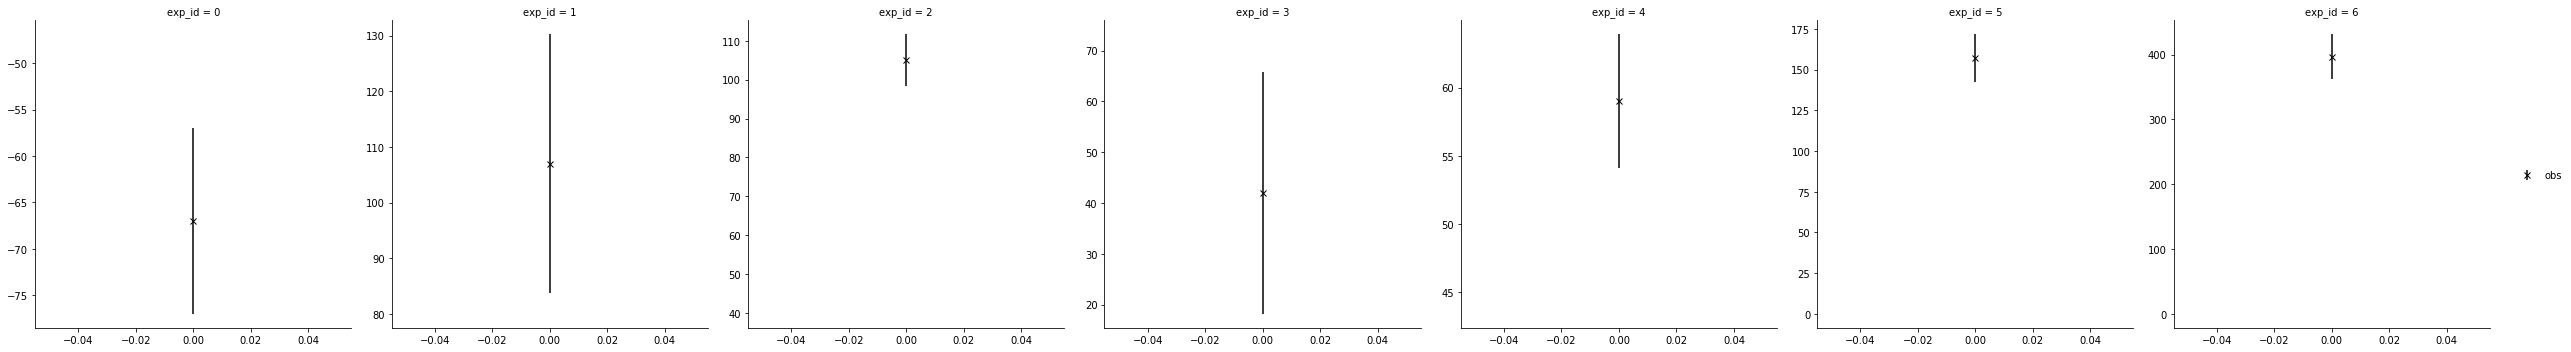

In [9]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(modelfile, ap, pacevar='engine.pace', prev_runs=prev_runs)

## Set limits and generate uniform initial priors

In [ ]:
from pyabc import Distribution, RV
limits = {'calcium_sr.V_SR': (0, 0.1),
          'log_calcium_sr.Buf_tot': (0, 6.),
          'log_calcium_sr.Km_Buf': (0, 3.),
          'log_ca_diff.tau_tr': (0, 3.),
          'serca.V_max': (0, 1.),
          'log_jleak.k_leak': (-7, -5),
          'ryr.k_RyR': (0, 0.1),
          'icab.g_Cab': (0, 0.01),
          'inab.g_Nab': (0, 0.01),
          'incx.k_NCX': (0, 10),
          'inak.i_NaK_max': (0, 10),
          'ipca.g_pCa': (0, 0.1),
          'calcium.D_Ca': (0, 1e2),
          'calcium.Buf_tot': (0, 1e2),
          'calcium.Km_Buf': (0, 10),
          'ical.k_fCass': (0, 10),
         }
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [ ]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "whole_cell.db"))

In [ ]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [ ]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [ ]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1e4),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.742034919710861, '1': 0.5104332251839483, '2': 1.753123460328047, '3': 0.19534724991847946, '4': 1.3338160267724242, '5': 1.1831023514309071, '6': 1.2821427666553327}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [ ]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [ ]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-08-05 19:21:59.287702, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


# Results analysis

In [ ]:
from pyabc import History

In [ ]:
print(db_path)
history = History(db_path)
history.all_runs()

In [ ]:
history.id = 1

In [ ]:
df, w = history.get_distribution(m=0)

In [ ]:
df.describe()

In [ ]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [ ]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [ ]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [ ]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=observations)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]#, "time, ms","voltage, mV"]
#ylabels = ["normalised current density, pA/pF", "activation", "inactivation", "recovery"]#, "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [ ]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp_id',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

In [ ]:
grid2 = plot_sim_results_all(samples)

In [ ]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [ ]:
import numpy as np

In [ ]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

In [ ]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [ ]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

In [ ]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [ ]:
print(np.mean(output))
print(np.std(output))

In [ ]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [ ]:
print(np.mean(output))
print(np.std(output))

In [ ]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

In [ ]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [ ]:
print(np.mean(output))
print(np.std(output))

In [ ]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))